### SetUp

In [1]:
!sudo apt-get install build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install ultralytics supervision opencv-python gdown deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

### Data

In [5]:
# Download and unzip pigs-tracking.zip
!gdown https://drive.google.com/uc?id=1PJyZedDyN06WiEGs0KTSWs7VcHuhNBGD -O /content/pigs-tracking.zip
!unzip /content/pigs-tracking.zip -d /content/videos

# Download and unzip pigs-yolov8-weights.zip
!gdown https://drive.google.com/uc?id=1YTbpI-m27oDJdGivKA1x01MA37Kv8_5- -O /content/pigs-yolov8-weights.zip
!unzip /content/pigs-yolov8-weights.zip -d /content

Downloading...
From (original): https://drive.google.com/uc?id=1PJyZedDyN06WiEGs0KTSWs7VcHuhNBGD
From (redirected): https://drive.google.com/uc?id=1PJyZedDyN06WiEGs0KTSWs7VcHuhNBGD&confirm=t&uuid=5aedc5d4-b5dd-4e19-bcf5-a357073a10a5
To: /content/pigs-tracking.zip
100% 1.18G/1.18G [00:22<00:00, 52.7MB/s]
Archive:  /content/pigs-tracking.zip
  inflating: /content/videos/Test Vid 1.mp4  
  inflating: /content/videos/Test Vid 2.mp4  
  inflating: /content/videos/Test Vid 3.mp4  
  inflating: /content/videos/Test Vid 5.mp4  
  inflating: /content/videos/Test Vid 8.mp4  
  inflating: /content/videos/Test Vid 6.mp4  
  inflating: /content/videos/Test Vid 7.mp4  
Downloading...
From (original): https://drive.google.com/uc?id=1YTbpI-m27oDJdGivKA1x01MA37Kv8_5-
From (redirected): https://drive.google.com/uc?id=1YTbpI-m27oDJdGivKA1x01MA37Kv8_5-&confirm=t&uuid=46f3ae42-2f80-4157-9217-70604a7097c3
To: /content/pigs-yolov8-weights.zip
100% 169M/169M [00:09<00:00, 18.5MB/s]
Archive:  /content/pigs-yol

### Code

In [8]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
from IPython.display import Video, display
import matplotlib
matplotlib.use('Agg')
from deep_sort_realtime.deepsort_tracker import DeepSort
import supervision as sv
import gc
import pandas as pd

class VideoTracker:
    def __init__(self, model_path, pig_class_id=0, output_dir="tracked_videos_output", tracker_type="deepsort"):
        print("Initializing VideoTracker...")
        self.model = YOLO(model_path)
        self.pig_class_id = pig_class_id
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"Output directory set to: {self.output_dir}")

        self.tracker_type = tracker_type.lower()
        self.tracker = None

        if self.tracker_type == "deepsort":
            self.tracker = DeepSort(
                max_iou_distance=0.7,
                max_age=30,
                n_init=3,
                nn_budget=100
            )
            print("DeepSORT tracker loaded successfully!")
        elif self.tracker_type == "bytetrack":
            self.tracker = sv.ByteTrack()
            print("Supervision ByteTrack tracker loaded successfully!")
        else:
            raise ValueError(f"Unsupported tracker type: {tracker_type}. Choose 'deepsort' or 'bytetrack'.")

        self.box_annotator = sv.BoxAnnotator(thickness=2)
        self.label_annotator = sv.LabelAnnotator(
            text_thickness=2,
            text_scale=1,
            text_color=sv.Color.BLACK,
            color=sv.Color.WHITE
        )
        self.trace_annotator = sv.TraceAnnotator(
            thickness=2,
            trace_length=30
        )
        print(f"YOLOv8 model and {self.tracker_type.upper()} tracker loaded successfully!")

    def process_video(self, video_path):
        print(f"\n--- Processing video: {os.path.basename(video_path)} using {self.tracker_type.upper()} ---")
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video file {video_path}")
            return

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        video_filename = os.path.basename(video_path)
        output_video_name = f"tracked_{self.tracker_type}_{os.path.splitext(video_filename)[0]}.mp4"
        output_video_path = os.path.join(self.output_dir, output_video_name)

        csv_filename = f"{os.path.splitext(video_filename)[0]}_{self.tracker_type}_tracking_data.csv"
        csv_path = os.path.join(self.output_dir, csv_filename)
        tracking_data = []

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            results = self.model.predict(source=frame, verbose=False)[0]

            annotated_frame = frame.copy()

            if self.tracker_type == "deepsort":

                current_frame_detections_for_tracker = []
                for r in results:
                    boxes = r.boxes
                    for box in boxes:
                        x1, y1, x2, y2 = box.xyxy[0].tolist()
                        conf = box.conf[0].item()
                        cls = int(box.cls[0].item())

                        if cls == self.pig_class_id and conf > 0.5:
                            bbox_xywh = [x1, y1, x2 - x1, y2 - y1]
                            current_frame_detections_for_tracker.append((bbox_xywh, conf, cls))

                tracked_objects = self.tracker.update_tracks(current_frame_detections_for_tracker, frame=frame)

                dark_blue_color = (255, 0, 0)
                bbox_thickness = 4
                text_thickness = 3

                for track in tracked_objects:
                    if not track.is_confirmed():
                        continue
                    track_id = track.track_id
                    ltrb = track.to_ltrb()
                    x1, y1, x2, y2 = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])
                    conf_val = 1.0

                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), dark_blue_color, bbox_thickness)
                    text = f"ID: {track_id} C:{conf_val:.2f}"
                    cv2.putText(annotated_frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, dark_blue_color, text_thickness)

                    tracking_data.append({
                        'frame_id': frame_count,
                        'object_id': int(track_id),
                        'bbox_x1': x1,
                        'bbox_y1': y1,
                        'bbox_x2': x2,
                        'bbox_y2': y2,
                        # 'confidence': float(conf_val)
                        'YOLO Detect confidence': conf  # That is YOLO Detection Value
                    })

            elif self.tracker_type == "bytetrack":
                detections_sv = sv.Detections.from_ultralytics(results)
                detections_sv = detections_sv[detections_sv.class_id == self.pig_class_id]

                tracked_detections_sv = self.tracker.update_with_detections(detections=detections_sv)

                labels = []
                for i in range(len(tracked_detections_sv.xyxy)):
                    track_id = tracked_detections_sv.tracker_id[i]
                    if track_id is not None:
                        labels.append(f"pig {track_id}")
                        x1, y1, x2, y2 = tracked_detections_sv.xyxy[i].astype(int)
                        conf = tracked_detections_sv.confidence[i]

                        tracking_data.append({
                            'frame_id': frame_count,
                            'object_id': int(track_id),
                            'bbox_x1': x1,
                            'bbox_y1': y1,
                            'bbox_x2': x2,
                            'bbox_y2': y2,
                            'confidence': float(conf)
                        })
                    else:
                        labels.append("")

                annotated_frame = self.box_annotator.annotate(scene=annotated_frame, detections=tracked_detections_sv)
                annotated_frame = self.label_annotator.annotate(scene=annotated_frame, detections=tracked_detections_sv, labels=labels)
                annotated_frame = self.trace_annotator.annotate(scene=annotated_frame, detections=tracked_detections_sv)

            out.write(annotated_frame)
            frame_count += 1

            if frame_count % 200 == 0:
                print(f"Processed {frame_count} frames for {os.path.basename(video_path)} using {self.tracker_type.upper()}")
                gc.collect()

        cap.release()
        out.release()

        print(f"Tracking complete for {os.path.basename(video_path)} using {self.tracker_type.upper()}! Output video saved to: {output_video_path}")

        if tracking_data:
            df = pd.DataFrame(tracking_data)
            df.to_csv(csv_path, index=False)
            print(f"Tracking data saved to: {csv_path}")
        else:
            print(f"No tracking data to save for {os.path.basename(video_path)} using {self.tracker_type.upper()}.")

        del cap, out, frame, results, tracking_data
        if self.tracker_type == "deepsort":
            del current_frame_detections_for_tracker, tracked_objects
        elif self.tracker_type == "bytetrack":
            del detections_sv, tracked_detections_sv, labels
        gc.collect()


video_files = [
    "/content/videos/Test Vid 1.mp4",
    # "/content/videos/Test Vid 2.mp4",
    # "/content/videos/Test Vid 3.mp4",
    # "/content/videos/Test Vid 5.mp4",
    # "/content/videos/Test Vid 6.mp4",
    # "/content/videos/Test Vid 7.mp4",
    # "/content/videos/Test Vid 8.mp4"
]

model_path = '/content/v9/weights/best.pt'
output_base_dir = "/content/tracked_videos"
pig_class_id = 0


In [9]:
for video_file in video_files:

    deepsort_tracker_instance = VideoTracker(
        model_path=model_path,
        pig_class_id=pig_class_id,
        output_dir=output_base_dir,
        tracker_type="deepsort"
    )
    deepsort_tracker_instance.process_video(video_file)
    del deepsort_tracker_instance
    gc.collect()

Initializing VideoTracker...
Output directory set to: /content/tracked_videos
DeepSORT tracker loaded successfully!
YOLOv8 model and DEEPSORT tracker loaded successfully!

--- Processing video: Test Vid 1.mp4 using DEEPSORT ---
Processed 200 frames for Test Vid 1.mp4 using DEEPSORT
Processed 400 frames for Test Vid 1.mp4 using DEEPSORT
Processed 600 frames for Test Vid 1.mp4 using DEEPSORT
Processed 800 frames for Test Vid 1.mp4 using DEEPSORT
Processed 1000 frames for Test Vid 1.mp4 using DEEPSORT
Processed 1200 frames for Test Vid 1.mp4 using DEEPSORT
Processed 1400 frames for Test Vid 1.mp4 using DEEPSORT
Tracking complete for Test Vid 1.mp4 using DEEPSORT! Output video saved to: /content/tracked_videos/tracked_deepsort_Test Vid 1.mp4
Tracking data saved to: /content/tracked_videos/Test Vid 1_deepsort_tracking_data.csv


In [10]:
for video_file in video_files:

    bytetrack_tracker_instance = VideoTracker(
        model_path=model_path,
        pig_class_id=pig_class_id,
        output_dir=output_base_dir,
        tracker_type="bytetrack"
    )
    bytetrack_tracker_instance.process_video(video_file)
    del bytetrack_tracker_instance
    gc.collect()

Initializing VideoTracker...
Output directory set to: /content/tracked_videos
Supervision ByteTrack tracker loaded successfully!
YOLOv8 model and BYTETRACK tracker loaded successfully!

--- Processing video: Test Vid 1.mp4 using BYTETRACK ---
Processed 200 frames for Test Vid 1.mp4 using BYTETRACK
Processed 400 frames for Test Vid 1.mp4 using BYTETRACK
Processed 600 frames for Test Vid 1.mp4 using BYTETRACK
Processed 800 frames for Test Vid 1.mp4 using BYTETRACK
Processed 1000 frames for Test Vid 1.mp4 using BYTETRACK
Processed 1200 frames for Test Vid 1.mp4 using BYTETRACK
Processed 1400 frames for Test Vid 1.mp4 using BYTETRACK
Tracking complete for Test Vid 1.mp4 using BYTETRACK! Output video saved to: /content/tracked_videos/tracked_bytetrack_Test Vid 1.mp4
Tracking data saved to: /content/tracked_videos/Test Vid 1_bytetrack_tracking_data.csv


### Export **∀** Videoz

In [11]:
# --- WebM Conversion and Display ---

input_mp4_dir = output_base_dir # Use the same directory where tracked MP4s are saved
output_webm_dir = output_base_dir # Changed to save WebM files in the same directory

os.makedirs(output_webm_dir, exist_ok=True)

mp4_files_to_convert = [
    os.path.join(input_mp4_dir, f)
    for f in os.listdir(input_mp4_dir)
    if f.endswith('.mp4')
]

if not mp4_files_to_convert:
    print(f"No MP4 files found in {input_mp4_dir} to convert to WebM.")
else:
    print(f"\nFound {len(mp4_files_to_convert)} MP4 files to convert to WebM and display.")
    for found_mp4_path in mp4_files_to_convert:
        if not os.path.exists(found_mp4_path):
            print(f"Error: Input MP4 file not found at {found_mp4_path} - Skipping.")
            continue

        base_name = os.path.splitext(os.path.basename(found_mp4_path))[0]
        # The WebM file name will now implicitly include the tracker type from the base_name
        output_webm_path = os.path.join(output_webm_dir, f"{base_name}.webm")

        print(f"\n Converting '{os.path.basename(found_mp4_path)}' to WebM...")

        get_ipython().system(f'ffmpeg -i "{found_mp4_path}" -vcodec vp9 -acodec libvorbis -b:v 500k -threads 8 -deadline realtime -vf scale=960:-2 -cpu-used 7 "{output_webm_path}" -y > /dev/null 2>&1')

        if os.path.exists(output_webm_path):
            print(f"Conversion complete for {os.path.basename(found_mp4_path)}. Saved to: {output_webm_path}")
            print(f"\n Displaying {os.path.basename(output_webm_path)}:")
            display(Video(output_webm_path, embed=True, html_attributes="controls autoplay loop"))
        else:
            print(f"Error: WebM file not found after conversion for {os.path.basename(found_mp4_path)}. Cannot display.")

print("\nAll specified MP4 videos have been processed for WebM conversion and display.")

Output hidden; open in https://colab.research.google.com to view.

In [12]:
!cp -r /content/tracked_videos /content/drive/MyDrive/Data

### Analysis

In [13]:
import pandas as pd
import os

output_base_dir = "/content/tracked_videos"
deepsort_csv_path = os.path.join(output_base_dir, "Test Vid 1_deepsort_tracking_data.csv")
bytetrack_csv_path = os.path.join(output_base_dir, "Test Vid 1_bytetrack_tracking_data.csv")

# Load CSV files
deepsort_df = pd.read_csv(deepsort_csv_path)
bytetrack_df = pd.read_csv(bytetrack_csv_path)

In [14]:
# Display info
print("DeepSORT Tracking Data Info:")
print(deepsort_df.info())
print(deepsort_df.head())

DeepSORT Tracking Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frame_id                3390 non-null   int64  
 1   object_id               3390 non-null   int64  
 2   bbox_x1                 3390 non-null   int64  
 3   bbox_y1                 3390 non-null   int64  
 4   bbox_x2                 3390 non-null   int64  
 5   bbox_y2                 3390 non-null   int64  
 6   YOLO Detect confidence  3390 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 185.5 KB
None
   frame_id  object_id  bbox_x1  bbox_y1  bbox_x2  bbox_y2  \
0         2          1     1581      963     1884     1052   
1         2          2      502      928      844     1077   
2         3          1     1534      973     1856     1068   
3         3          2      525      909      909     1079   
4         4          

In [15]:
print("\nByteTrack Tracking Data Info:")
print(bytetrack_df.info())
print(bytetrack_df.head())


ByteTrack Tracking Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   frame_id    2894 non-null   int64  
 1   object_id   2894 non-null   int64  
 2   bbox_x1     2894 non-null   int64  
 3   bbox_y1     2894 non-null   int64  
 4   bbox_x2     2894 non-null   int64  
 5   bbox_y2     2894 non-null   int64  
 6   confidence  2894 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 158.4 KB
None
   frame_id  object_id  bbox_x1  bbox_y1  bbox_x2  bbox_y2  confidence
0         0          1     1630      946     1920     1031    0.886240
1         0          2      476      949      774     1079    0.877738
2         1          1     1590      963     1877     1052    0.849109
3         1          2      523      928      821     1077    0.847762
4         2          2      524      928      821     1077    0.853495


In [16]:
# Get unique object IDs and their counts
deepsort_object_ids = deepsort_df['object_id'].value_counts()
bytetrack_object_ids = bytetrack_df['object_id'].value_counts()

# Print the results
print("DeepSORT Unique Object IDs and Counts:")
print(deepsort_object_ids)

print("\nByteTrack Unique Object IDs and Counts:")
print(bytetrack_object_ids)

DeepSORT Unique Object IDs and Counts:
object_id
1     1095
3      778
12     543
2      470
15     248
6      165
14      60
8       31
Name: count, dtype: int64

ByteTrack Unique Object IDs and Counts:
object_id
1     1188
2      443
5      421
10     315
13     269
15     249
7        2
6        2
12       2
4        1
9        1
8        1
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt

# Enable plotting in Colab
%matplotlib inline

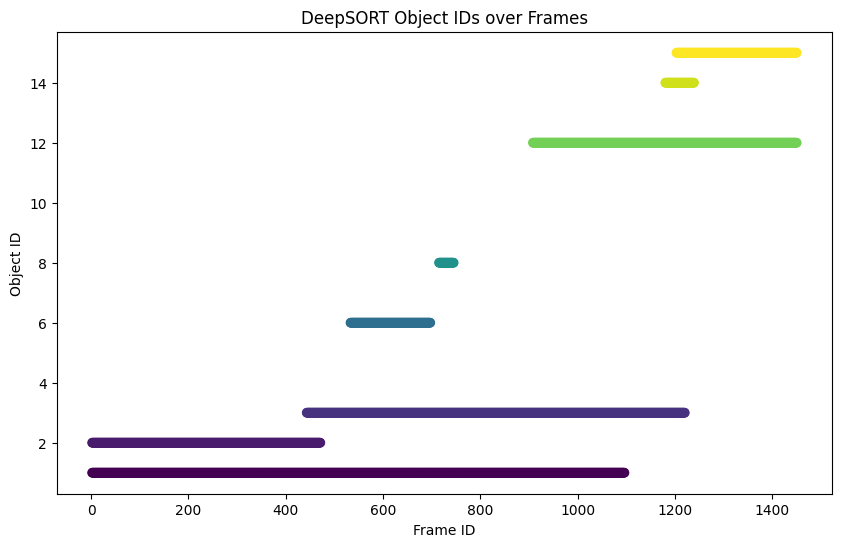

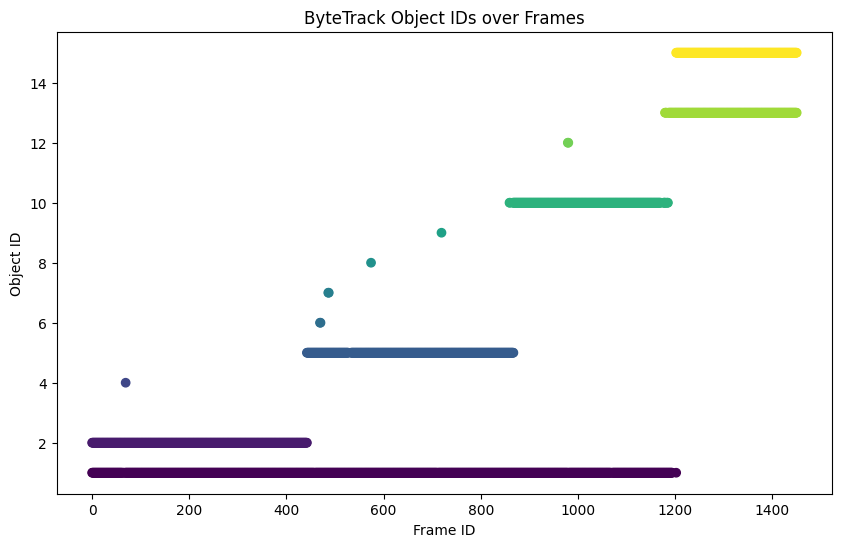

In [18]:
# Plot object IDs over frames for DeepSORT
plt.figure(figsize=(10, 6))
plt.scatter(deepsort_df['frame_id'], deepsort_df['object_id'], c=deepsort_df['object_id'], cmap='viridis')
plt.xlabel('Frame ID')
plt.ylabel('Object ID')
plt.title('DeepSORT Object IDs over Frames')
plt.show()

# Plot object IDs over frames for ByteTrack
plt.figure(figsize=(10, 6))
plt.scatter(bytetrack_df['frame_id'], bytetrack_df['object_id'], c=bytetrack_df['object_id'], cmap='viridis')
plt.xlabel('Frame ID')
plt.ylabel('Object ID')
plt.title('ByteTrack Object IDs over Frames')
plt.show()

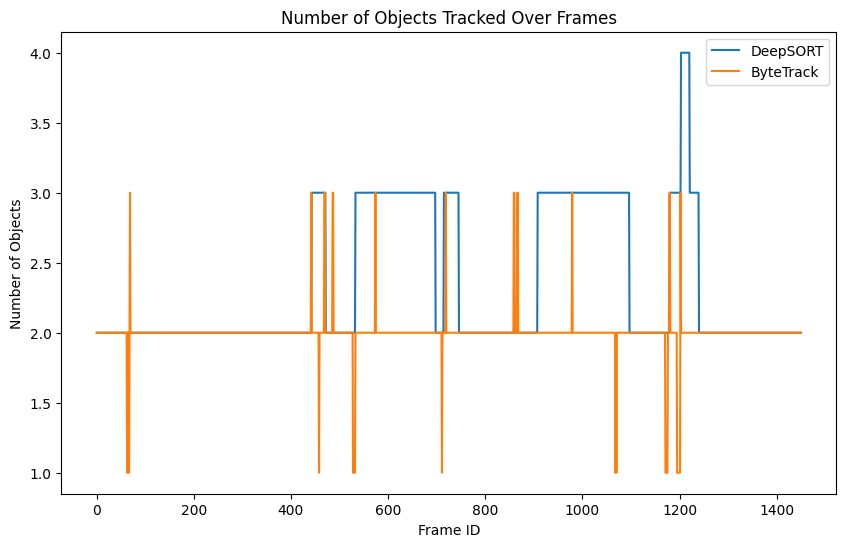

In [19]:
# Count objects at each frame for DeepSORT
deepsort_frame_counts = deepsort_df['frame_id'].value_counts().sort_index()

# Count objects at each frame for ByteTrack
bytetrack_frame_counts = bytetrack_df['frame_id'].value_counts().sort_index()

# Plot object counts over frames
plt.figure(figsize=(10, 6))
plt.plot(deepsort_frame_counts.index, deepsort_frame_counts.values, label='DeepSORT')
plt.plot(bytetrack_frame_counts.index, bytetrack_frame_counts.values, label='ByteTrack')
plt.xlabel('Frame ID')
plt.ylabel('Number of Objects')
plt.title('Number of Objects Tracked Over Frames')
plt.legend()
plt.show()

In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import os

# --- IoU Functions ---

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area != 0 else 0.0

def calculate_best_match_iou_per_frame(tracker1_df, tracker2_df, iou_threshold=0.01):
    """Calculates best-match IoU using Hungarian algorithm."""
    all_matched_ious = []
    common_frames = sorted(set(tracker1_df['frame_id']) & set(tracker2_df['frame_id']))

    for frame_id in common_frames:
        boxes1 = tracker1_df[tracker1_df['frame_id'] == frame_id][['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values
        boxes2 = tracker2_df[tracker2_df['frame_id'] == frame_id][['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values

        if len(boxes1) == 0 or len(boxes2) == 0:
            continue

        iou_matrix = np.zeros((len(boxes1), len(boxes2)))
        for i, box1 in enumerate(boxes1):
            for j, box2 in enumerate(boxes2):
                iou_matrix[i, j] = calculate_iou(box1, box2)

        cost_matrix = 1 - iou_matrix
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        matched_ious = [iou_matrix[r, c] for r, c in zip(row_ind, col_ind) if iou_matrix[r, c] >= iou_threshold]
        all_matched_ious.extend(matched_ious)

    return np.mean(all_matched_ious) if all_matched_ious else 0.0

# --- Metrics Functions ---

def calculate_iou_between_algorithms(deepsort_df, bytetrack_df):
    """Simplified IoU comparison based on first frame detection overlap."""
    ious = []
    for frame_id in deepsort_df['frame_id'].unique():
        d_frame = deepsort_df[deepsort_df['frame_id'] == frame_id]
        b_frame = bytetrack_df[bytetrack_df['frame_id'] == frame_id]
        for d_id in d_frame['object_id'].unique():
            d_obj = d_frame[d_frame['object_id'] == d_id]
            for b_id in b_frame['object_id'].unique():
                b_obj = b_frame[b_frame['object_id'] == b_id]
                if not d_obj.empty and not b_obj.empty:
                    d_box = d_obj[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values[0]
                    b_box = b_obj[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values[0]
                    iou = calculate_iou(d_box, b_box)
                    ious.append(iou)
    return np.mean(ious) if ious else 0.0

def calculate_mota_like(gt_df, pred_df):
    tp = fp = fn = ids = 0
    for frame_id in gt_df['frame_id'].unique():
        gt_frame = gt_df[gt_df['frame_id'] == frame_id]
        pred_frame = pred_df[pred_df['frame_id'] == frame_id]

        gt_ids = set(gt_frame['object_id'])
        pred_ids = set(pred_frame['object_id'])

        tp += len(gt_ids & pred_ids)
        fp += len(pred_ids - gt_ids)
        fn += len(gt_ids - pred_ids)

        for obj_id in gt_ids:
            gt_obj = gt_frame[gt_frame['object_id'] == obj_id]
            pred_obj = pred_frame[pred_frame['object_id'] == obj_id]
            if not gt_obj.empty and not pred_obj.empty:
                if not np.allclose(gt_obj[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values[0],
                                   pred_obj[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values[0]):
                    ids += 1

    denom = tp + fp + fn
    return 1 - ((fp + fn + ids) / denom) if denom > 0 else 0.0

def calculate_id_switches(df):
    switches = 0
    for obj_id in df['object_id'].unique():
        frames = df[df['object_id'] == obj_id]['frame_id'].sort_values()
        switches += (frames.diff() > 1).sum()
    return int(switches)

def calculate_fragmentation(df):
    fragments = 0
    for obj_id in df['object_id'].unique():
        obj_df = df[df['object_id'] == obj_id].sort_values('frame_id')
        fragments += obj_df['frame_id'].diff().gt(1).sum()
    return int(fragments)

def calculate_tracking_duration(df):
    durations = []
    for obj_id in df['object_id'].unique():
        frames = df[df['object_id'] == obj_id]['frame_id']
        if not frames.empty:
            durations.append(frames.max() - frames.min() + 1)
    return np.mean(durations) if durations else 0

# --- Load Data ---

output_base_dir = "/content/tracked_videos"
deepsort_csv = os.path.join(output_base_dir, "Test Vid 1_deepsort_tracking_data.csv")
bytetrack_csv = os.path.join(output_base_dir, "Test Vid 1_bytetrack_tracking_data.csv")

try:
    deepsort_df = pd.read_csv(deepsort_csv)
    bytetrack_df = pd.read_csv(bytetrack_csv)
    print("CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# --- Calculate Metrics ---

# DeepSORT
deepsort_id_switches = calculate_id_switches(deepsort_df)
deepsort_fragmentation = calculate_fragmentation(deepsort_df)
deepsort_tracking_duration = calculate_tracking_duration(deepsort_df)

# ByteTrack
bytetrack_id_switches = calculate_id_switches(bytetrack_df)
bytetrack_fragmentation = calculate_fragmentation(bytetrack_df)
bytetrack_tracking_duration = calculate_tracking_duration(bytetrack_df)

# IoU Metrics
mean_iou_simple = calculate_iou_between_algorithms(deepsort_df, bytetrack_df)
mean_iou_best_match = calculate_best_match_iou_per_frame(deepsort_df, bytetrack_df)

# MOTA-like
mota_ds_gt = calculate_mota_like(deepsort_df, bytetrack_df)
mota_bt_gt = calculate_mota_like(bytetrack_df, deepsort_df)

# --- Print Results ---

print("\n--- DeepSORT Metrics ---")
print(f"ID Switches: {deepsort_id_switches}")
print(f"Fragmentation: {deepsort_fragmentation}")
print(f"Tracking Duration: {deepsort_tracking_duration:.2f} frames")

print("\n--- ByteTrack Metrics ---")
print(f"ID Switches: {bytetrack_id_switches}")
print(f"Fragmentation: {bytetrack_fragmentation}")
print(f"Tracking Duration: {bytetrack_tracking_duration:.2f} frames")

print("\n--- Cross-Algorithm Metrics ---")
print(f"Mean IoU (Simple): {mean_iou_simple:.4f}")
print(f"Mean IoU (Best-Match Hungarian): {mean_iou_best_match:.4f}")
print(f"MOTA-like (DeepSORT as GT): {mota_ds_gt:.4f}")
print(f"MOTA-like (ByteTrack as GT): {mota_bt_gt:.4f}")


CSV files loaded successfully.

--- DeepSORT Metrics ---
ID Switches: 0
Fragmentation: 0
Tracking Duration: 423.75 frames

--- ByteTrack Metrics ---
ID Switches: 13
Fragmentation: 13
Tracking Duration: 244.08 frames

--- Cross-Algorithm Metrics ---
Mean IoU (Simple): 0.4360
Mean IoU (Best-Match Hungarian): 0.8322
MOTA-like (DeepSORT as GT): 0.0004
MOTA-like (ByteTrack as GT): 0.0004



**DeepSORT Metrics**

ID Switches: 0  
Fragmentation: 0  
Average Tracking Duration: 423.75 frames

Interpretation:  
- No ID switches or fragmentations  
- Long tracking duration (approximately 424 frames or 14 seconds per object)  
- Indicates stable and uninterrupted tracking

---

**ByteTrack Metrics**

ID Switches: 13  
Fragmentation: 13  
Average Tracking Duration: 244.08 frames

Interpretation:  
- Frequent ID changes and interruptions in tracking  
- Shorter object tracking durations (approximately 244 frames or 8 seconds)  
- More fragmented and inconsistent tracking compared to DeepSORT

---

**Cross-Algorithm Metrics**

Mean IoU (Simple Overlap): 0.4360  
Mean IoU (Hungarian Best-Match): 0.8322

Interpretation:  
- Simple IoU shows moderate overlap between bounding boxes  
- Hungarian-matched IoU shows strong spatial alignment  
- Both trackers detect similar object regions despite ID mismatch

---

**MOTA-like Scores**

MOTA-like (DeepSORT as Ground Truth): 0.0004  
MOTA-like (ByteTrack as Ground Truth): 0.0004

Interpretation:  
- Very low scores due to ID switches, false positives, and false negatives  
- Poor ID consistency between the two trackers

---

**Summary Table**

Metric                          | DeepSORT   | ByteTrack  | Interpretation
-------------------------------|------------|------------|---------------------------------------------
ID Switches                    | 0          | 13         | DeepSORT maintains object identity better
Fragmentation                  | 0          | 13         | DeepSORT has smoother, uninterrupted tracks
Avg. Tracking Duration         | 423.75     | 244.08     | DeepSORT tracks objects longer
Mean IoU (Hungarian)           | 0.8322     | 0.8322     | Both detect similar regions accurately
MOTA-like Score                | 0.0004     | 0.0004     | Trackers disagree heavily on object identities

---

**Conclusion**

DeepSORT is better at maintaining consistent identity and continuous tracks  
ByteTrack is spatially accurate but suffers from ID inconsistency and fragmented tracking  
Use DeepSORT when identity consistency is important  
Use ByteTrack when spatial detection is the main priority
